# Epidemiological curves at regional level

This is a modified version of my notebook [Epidemiological curves using ECDC data](https://www.kaggle.com/panosc/epidemiological-curves-using-ecdc-data) that adds the regional dimension into the analysis.
This version used WHO data available from [Novel Corona Virus 2019 Dataset](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset) wich includes the number of reported cases and deaths in each country around the world at daily level, including regional detail for China and the US. In addition, I use the [COVID-19 in Italy](https://www.kaggle.com/sudalairajkumar/covid19-in-italy) and the [Covid19 data for Spain at regional level](https://www.kaggle.com/panosc/covid19-data-for-spain-at-regional-level) datasets to take into account the regional detail in Italy and Spain.

In [8]:
# the basic libraries needed for a quick analysis
library(data.table)
library(dplyr)
library(ggplot2)
library(leaflet)

dataDir <- "../data"
dt<-fread( paste(dataDir, "covid_19_data.csv", sep="/"),stringsAsFactors = F)
dti<-fread( paste(dataDir, "covid19_italy_region.csv", sep="/"),stringsAsFactors = F)
colnames(dt)<-c("SNo","Date", "Province","Country","Update","Confirmed","Deaths","Recovered")
dt<-select(dt,-SNo,-Update)
dt$Province[dt$Province=="France"|dt$Province=="United Kingdom"|dt$Province=="UK"|dt$Province=="Netherlands"|dt$Province=="Denmark"]<-""
dt<-dt[!dt$Province=="French Polynesia"]
dt$Date<-as.Date(dt$Date, "%m/%d/%Y")

The first report available is on 22 January 2020. It is convenient to convert the dates into a continuous counter, with that date as Day 0:

In [9]:
dt$day_cont<-as.numeric(as.Date(dt$Date)-as.Date(min(dt$Date)))

A few transformations to allow the comparison at province/region/state level, where available:

In [10]:
dt$province_country<-paste(dt$Province,dt$Country,sep = ", ")
dt$province_country[is.na(dt$Province)|dt$Province==""]<-dt$Country[is.na(dt$Province)|dt$Province==""]
dti$Date<-as.Date(dti$Date, "%Y-%m-%d")
dti$day_cont<-as.numeric(as.Date(dti$Date)-as.Date(min(dt$Date)))
dti<-dti[order(dti$day_cont,decreasing = T),]
dti_last<-dti[!duplicated(dti$RegionName),]
dti_last<-select(dti_last,Latitude,Longitude,TotalPositiveCases)

The regional distribution in Italy suggests that it makes sense to analyze data at this level. The different foci are probably at different stages in their evolution and since mobility has been minimized, they can now be considered as independent:

(the nice leaflet map may not plot correctly in the notebook, works fine locally though)

In [11]:
leaflet(data = dti_last) %>% addTiles() %>%
  addCircleMarkers( lng = dti_last$Longitude, lat = dti_last$Latitude, color = 'red', fillColor = "coyGreen",
                   radius = sqrt(dti_last$TotalPositiveCases)/5, opacity = .5)


HTML widgets cannot be represented in plain text (need html)

In [12]:

dti<-select(dti,RegionName,TotalPositiveCases,Deaths,Recovered,day_cont)
dti$province_country<-paste0(dti$RegionName,", Italy")
dti<-select(dti,-RegionName)
min_date<-min(dt$Date)
#dt<-dt[!(dt$Country=="Italy"|dt$Country=="Spain")]
dt<-dt[!(dt$Country=="Italy")]

dt<-select(dt,-Date,-Province,-Country)
setnames(dti, "TotalPositiveCases","Confirmed")

dt<-rbind(dt,dti)



Data at regional level are also available for Spain. They need however some processing:

In [14]:
dts <- fread(paste(dataDir, "/ccaa_covid19_casos.csv", sep="/"),stringsAsFactors = F)
dts$cod_ine<-NULL
days<-colnames(dts)[2:ncol(dts)]
days<-as.data.frame(cbind(day=c(1:length(days)),date=days))
days$day<-as.integer(as.character(days$day))

cc<-reshape(dts,direction = "long",idvar = "CCAA",timevar = "day",varying = list(2:ncol(dts)))
cc<-left_join(cc,days,by="day")
cc$day<-NULL
colnames(cc)<-c("Region","Confirmed","date")
cc$date<-as.character(cc$date)
cases<-cc

dts <- fread(paste(dataDir, "ccaa_covid19_fallecidos.csv", sep="/"),stringsAsFactors = F)
dts$cod_ine<-NULL
days<-colnames(dts)[2:ncol(dts)]
days<-as.data.frame(cbind(day=c(1:length(days)),date=days))
days$day<-as.integer(as.character(days$day))

cc<-reshape(dts,direction = "long",idvar = "CCAA",timevar = "day",varying = list(2:ncol(dts)))
cc<-left_join(cc,days,by="day")
cc$day<-NULL
colnames(cc)<-c("Region","Deaths","date")
cc$date<-as.character(cc$date)
deaths<-cc

dts <- fread(paste(dataDir, "ccaa_covid19_altas.csv", sep="/"),stringsAsFactors = F)
dts$cod_ine<-NULL
days<-colnames(dts)[2:ncol(dts)]
days<-as.data.frame(cbind(day=c(1:length(days)),date=days))
days$day<-as.integer(as.character(days$day))

cc<-reshape(dts,direction = "long",idvar = "CCAA",timevar = "day",varying = list(2:ncol(dts)))
cc<-left_join(cc,days,by="day")
cc$day<-NULL
colnames(cc)<-c("Region","Recovered","date")
cc$date<-as.character(cc$date)
recovered<-cc


qq<-dplyr::left_join(cases,deaths,by=c("Region",as.factor("date")))
qq<-left_join(qq,recovered,by=c("Region","date"))

qq[is.na(qq)]<-0
qq<-qq[!qq$Region=="Total",]
qq$province_country<-paste0(qq$Region,", Spain")

qq$date<-as.Date(qq$date, "%Y/%m/%d")
qq$day_cont<-as.numeric(as.Date(qq$date)-as.Date(min_date))

qq<-qq[order(qq$day_cont,decreasing = T),]
dts<-select(qq,Confirmed,Deaths,Recovered,day_cont,province_country)
dt<-rbind(dt,dts)
write.csv(dt,"dt.csv",row.names=F)

ERROR: Error: `by` can't contain join column `1` which is missing from LHS


In [15]:
last<-dt[order(dt$day_cont,decreasing = T),]
last<-last[!duplicated(last$province_country),]
last<-last[order(last$Confirmed,decreasing = T),]

The top-20 regions or countries in terms of total reported cases -at the moment- are:

In [16]:
print(last[1:20,])

    Confirmed Deaths Recovered day_cont      province_country
 1:   1242770  33407    936554      245    Maharashtra, India
 2:    945422  34266    818593      245     Sao Paulo, Brazil
 3:    796436  15291         0      245        California, US
 4:    742913  15372         0      245             Texas, US
 5:    690499  13618         0      245           Florida, US
 6:    665188  16206    594229      245          South Africa
 7:    664799  14376    525486      245             Argentina
 8:    639302   5461    562376      245 Andhra Pradesh, India
 9:    552674   8947    497377      245     Tamil Nadu, India
10:    533850   8228    432450      245      Karnataka, India
11:    483956  31252     77757      245                France
12:    451892  33090         0      245          New York, US
13:    432798  24840    365846      245                  Iran
14:    405843   4693    171883      130                Russia
15:    364543   5212    296183      245  Uttar Pradesh, India
16:    3

I concentrate on the top 8 regions or countries here, mainly to make reading the plots easier, but any other combination is possible

In [17]:
dd<-dt[dt$province_country %in% last$province_country[1:8]]

A first plot shows the total number of cases in those 8 regions or countries since Day 0: 

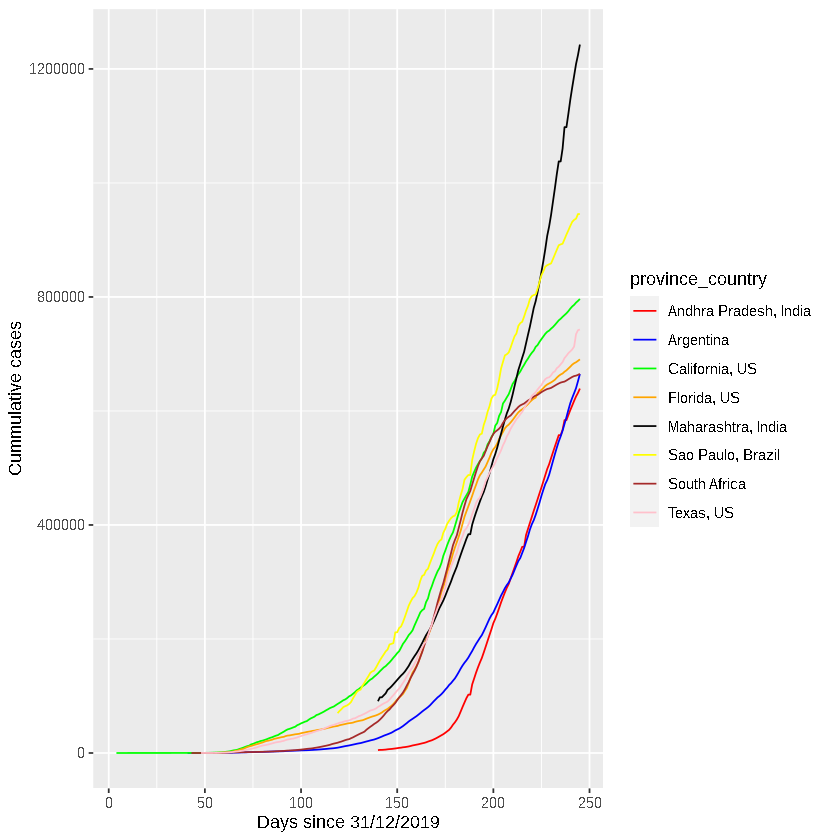

In [18]:
dd_0<-select(dd,province_country,Confirmed,day_cont)

ggplot(dd_0, aes(x = day_cont, y = Confirmed, colour = province_country)) + 
  geom_line() + 
  ylab(label="Cummulative cases") + 
  xlab("Days since 31/12/2019") + 
  scale_colour_manual(values=c("red", "blue","green","orange","black","yellow","brown","pink"))

The cases in Hubei, China appear as much higher than in other countries. Of course, the outbreaks started much earlier.

Let´s see what happens if we plot the evolution of the number of cases from the moment that 100 cases where reported in each region or country.

*(100 days is an arbitrary figure, but convenient for comparison purposes. Other figures, like 10 or 500 cases could give different results but simlar general conclusions) *

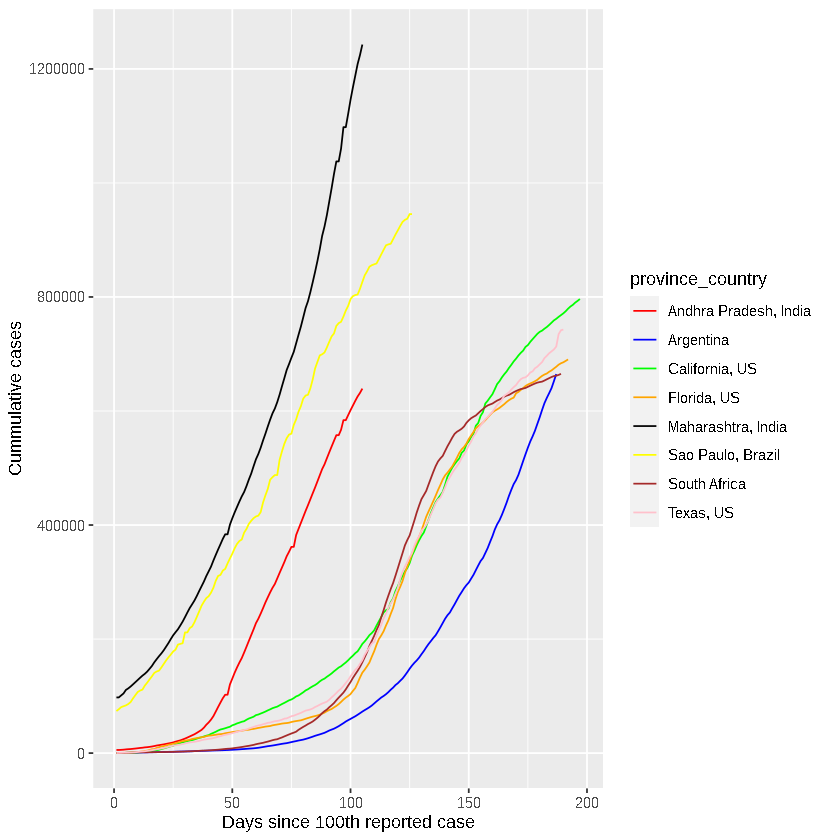

In [19]:
dd[,day_100_cases:=min(day_cont[Confirmed>100]), by=province_country]
dd$day_100<-dd$day_cont-dd$day_100_cases
dd<-dd[dd$day_100>0]

dd_100<-select(dd,province_country,day_100,Confirmed)

ggplot(dd_100, aes(x = day_100, y = Confirmed, colour = province_country)) + 
  geom_line() + 
  ylab(label="Cummulative cases") + 
  xlab("Days since 100th reported case") + 
  scale_colour_manual(values=c("red", "blue","green","orange","black","yellow","brown","pink"))

The picture becomes worrying now. Apart from South Korea, where the pandemic seems to be kept under control, most other regions or countries appear to be following a similar -or worse- pattern than China!!!

The same data in logarithmic scale:

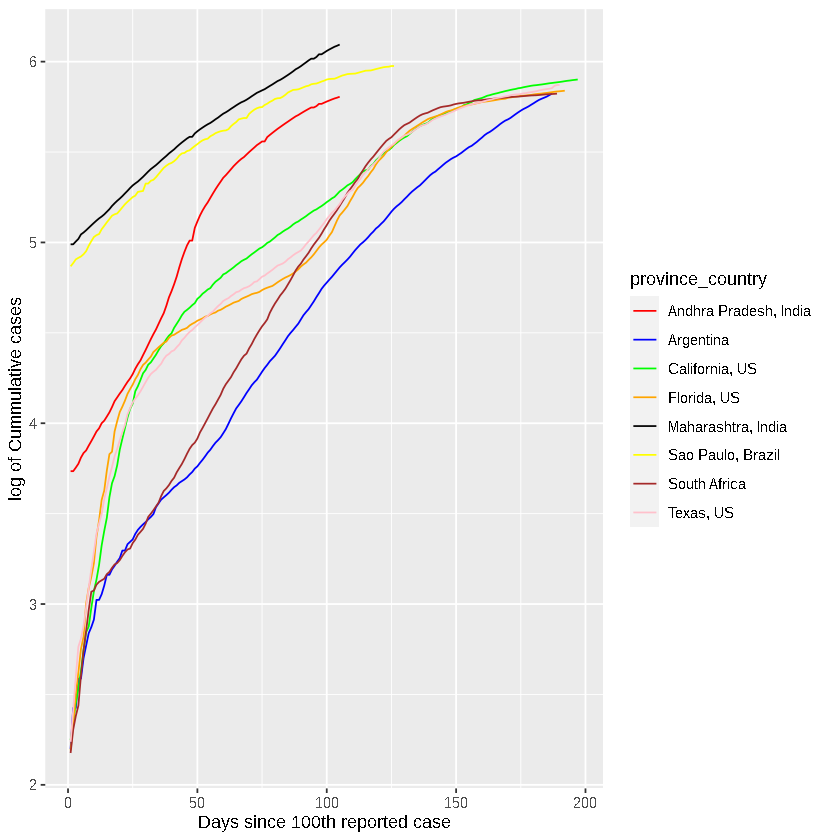

In [20]:
dd_log<-dd_100
dd_log$Confirmed<-log10(dd_log$Confirmed)
ggplot(dd_log, aes(x = day_100, y = Confirmed, colour = province_country)) + 
  geom_line() + 
  ylab(label="log of Cummulative cases") + 
  xlab("Days since 100th reported case") + 
  scale_colour_manual(values=c("red", "blue","green","orange","black","yellow","brown","pink"))

Extracting mortality rates based on reported cases and reported deaths is unreliable, since testing and reporting protocols differ significantly among countries. But simply comparing the ratio of reported deaths to reported cases could give a picture that can open the discussion:

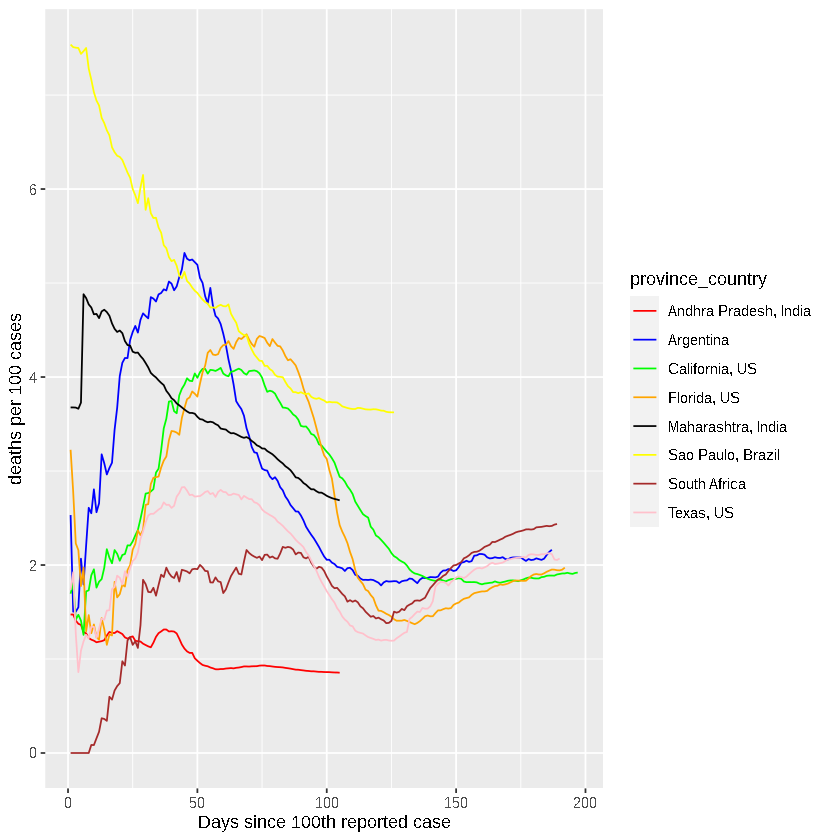

In [21]:
dd$deaths_to_cases<-dd$Deaths/dd$Confirmed*100
ggplot(dd, aes(x = day_100, y = deaths_to_cases, colour = province_country)) + 
  geom_line() + 
  ylab(label="deaths per 100 cases") + 
  xlab("Days since 100th reported case") + 
  scale_colour_manual(values=c("red", "blue","green","orange","black","yellow","brown","pink"))


It is still too early to draw robust conclusions, but the ratio in China seems to be stabilizing around 4.5 reported deaths from COVID-19 per 100 reported cases of infection.

In [22]:
write.csv(dd_100,"dd_100.csv",row.names=F)
write.csv(dd,"dd.csv",row.names=F)